In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

# Project back to street network

Load in the results of "SF 02", load in the street network, then project the points to the network.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import bz2
import tilemapbase

import opencrimedata.san_francisco
import opencrimedata.geometry
import opencrimedata.replace

## Load data

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")

In [4]:
def gen_streets():
    filename = os.path.join(datadir, "San Francisco Basemap Street Centerlines")
    for row in opencrimedata.san_francisco.load_street_centre_lines(filename):
        if opencrimedata.san_francisco.street_layer_accept(row):
            yield row

In [5]:
proj = opencrimedata.san_francisco.projector()

def proj_street(street):
    line = np.asarray(street.line)
    return np.asarray(proj(*line.T)).T

graph, graph_names = opencrimedata.geometry.graph_from_streets(gen_streets(), proj_street)

In [6]:
def gen():
    filename = os.path.join(datadir, "SF_Redist_1.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)

## Project

In [7]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        x, y = proj(*row.point)
        edge, t = graph.project_point_to_graph(x, y)
        xx, yy = graph.edge_to_coords(*edge, t)
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(xx, yy, inverse=True))
    
assign = AssignNew(gen(), seed=1234)
filename = os.path.join(datadir, "SF_Redist_2.csv.bz2")
with bz2.open(filename, "wt", newline="", encoding="UTF8") as f:
    opencrimedata.san_francisco.write(f, assign)

### Hashes

The hashes change from platform.  But the in matches the output of SF 02.

- in : `4f8b3ce83128039b0567fa9eaffcc13eb0e32a1bda559b31c0b84dcc0ca5dc68`
- out: `432ee84d48042e2cb38622054284488d5972da644488fc80b243bf79b4ebcc6b`
- counts: (2115909, 0)

In [8]:
assign.input_hash, assign.output_hash

('fa9c18406f206b9ebfc5a9c3209eb67581055d7105ad22056aa2d8f409d03a4a',
 'cb9b02404dbb0c7dde2a6815860b236955b331c02ae27c85504e818d0783fb9b')

In [9]:
assign.input_size, assign.failed_to_reassign_count

(2115909, 0)

## Load back in and check

Correlate against _original_ file.

In [4]:
def gen_old():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)
        
def gen_mid():
    filename = os.path.join(datadir, "SF_Redist_1.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)
        
def gen_new():
    filename = os.path.join(datadir, "SF_Redist_2.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)

In [5]:
old_data = list(gen_old())
print(len(old_data))
old_data = {row.idd : row for row in old_data}
print(len(old_data))

2119901
2119901


In [6]:
new_data = list(gen_new())
print(len(old_data))
new_data = {row.idd : row for row in new_data}
print(len(old_data))

2119901
2119901


In [7]:
mid_data = list(gen_mid())
print(len(mid_data))
mid_data = {row.idd : row for row in mid_data}
print(len(mid_data))

2115909
2115909


In [8]:
for idd, new_row in new_data.items():
    old_row = old_data[idd]
    assert tuple(old_row)[:4] == tuple(new_row)[:4]
    assert tuple(old_row)[5:] == tuple(new_row)[5:]
in_old_only = {idd for idd in old_data if idd not in new_data}
len(in_old_only)

3992

In [9]:
assert mid_data.keys() == new_data.keys()

## Some plots for paper

Again, compared to _original_.

In [10]:
new_pts, old_pts, mid_pts = [], [], []
for idd in new_data:
    new_pts.append(tilemapbase.project(*new_data[idd].point))
    old_pts.append(tilemapbase.project(*old_data[idd].point))
    mid_pts.append(tilemapbase.project(*mid_data[idd].point))

In [11]:
new_pts = np.asarray(new_pts)
old_pts = np.asarray(old_pts)
mid_pts = np.asarray(mid_pts)
new_pts.shape

(2115909, 2)

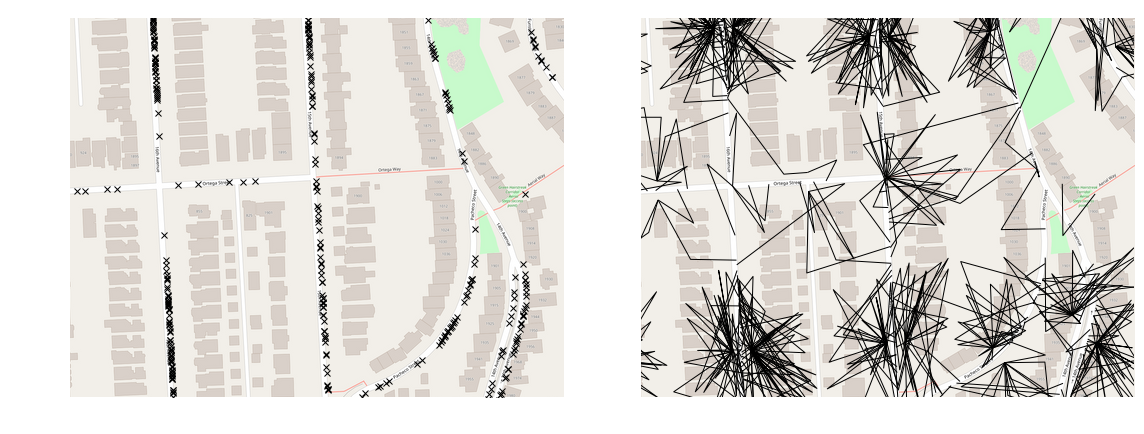

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for ax in axes:
    ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
    plotter.plot(ax)
axes[0].scatter(*new_pts.T, marker="x", color="black", linewidth=1)
lines = list(zip(old_pts, mid_pts, new_pts))
l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
axes[1].add_collection(l)

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

In [14]:
fig.savefig("san_fran_two_stage_network_projection.png", dpi=150)